In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import pandas
import anndata
import tangram

# from IPython.display import Audio
# tada = 'C://Users/stephanies/tada.mp3'

from celltype_mapping import TangramMapping, bin_gene_table, convert_to_anndata

In [3]:
sys.path.append(os.getcwd() + '/../gene_panel_selection')
sys.path.append(os.getcwd() + '/../segmentation')

from segmentation import SpotTable
from gene_panel_selection import ExpressionDataset

Relevant code for loading raw(ish) data and convering to anndata for use with tangram. Suggest that these data be saved for later loading if they will be reused as they are large and this takes some time. If you've already done this skip down...

In [4]:
# base network data path
data_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis'

# raw spatial data
sp_data_path = data_path + '/NHP_spatial/barseq/20220524mtg_panel_test'
sp_data_file = sp_data_path + '/alldata20220608.mat'

# spatial AnnData file
sp_anndata_file = sp_data_path + '/macaque-barseq-20220524mtg.h5ad'

# raw single cell data
sc_data_path = data_path + '/Nik/Analyses_for_great_apes_paper/Shiny_obj_final/rhesus'
rnaSeq_data_file = sc_data_path + '/data.feather'
rnaSeq_anno_file = sc_data_path + '/anno.feather'

# single cell AnnData file
sc_anndata_file = data_path + '/NHP_spatial/snRNAseq_data/macaque_MTG_logcpm.h5ad'

# path for storing tangram mapping
tg_mapping_path = sp_data_path + '/mapping'

Read raw SC expression data

In [ ]:
expression = pd.read_feather(rnaSeq_data_file)
expression.set_index('sample_id', inplace=True)
annotations = pd.read_feather(rnaSeq_anno_file)
annotations.set_index('sample_id', inplace=True)

exp_data = ExpressionDataset(
    expression_data=expression,  
    expression_type='logcpm',
    annotation_data=annotations,
)

Read raw spatial data

In [5]:
def convert_gene_names(genes):
    # convert some gene names  (dataset.R : convert_gene_names)
    # (to / from what?)
    mapping = {"Tafa1": "Fam19a1", "Tafa2": "Fam19a2", "Ccn2": "Ctgf"}
    return [mapping.get(v, v) for v in genes]


# read .mat file and convert to cell x gene expression matrix
# (see 00_convert_to_rds.R)
data = h5py.File(sp_data_file)

genes = []
for ref in data['neurons/genes'][0, :]:
    genes.append(np.array(data[ref])[:, 0].tobytes().decode('utf16'))
genes = convert_gene_names(genes)
    
cell_ids = np.array(data['neurons/id'][0]).astype(int)
    
expmat = scipy.sparse.csr_matrix(
    (data['neurons/expmat/data'], data['neurons/expmat/ir'], data['neurons/expmat/jc']),
    shape=(data['neurons/genes'].shape[1], data['neurons/id'].shape[1]),
    dtype='ubyte',
).toarray()

expmat = pandas.DataFrame(expmat.T, columns=genes, index=cell_ids)

In [7]:
# Convert expression matrix to AnnData
ad_sp = anndata.AnnData(expmat.to_numpy(), dtype='ubyte')
ad_sp.obs_names = expmat.index.astype('str')
ad_sp.var_names = expmat.columns
ad_sp.obs['x'] = data['neurons/pos'][0, :]
ad_sp.obs['y'] = data['neurons/pos'][1, :]
ad_sp

AnnData object with n_obs × n_vars = 78219 × 177
    obs: 'x', 'y'

In [8]:
ad_sp.write_h5ad(sp_anndata_file)

If you already have data saved out TangramMapping class can be instantiated from those files

In [9]:
meta = {
    'snRNAseq': 'logcpm',
    'snRNAseq_region': 'MTG',
    'spatial_method': 'barseq',
    'spatial_region': 'MTG'
}
tg_map = TangramMapping(
    sc_data=sc_anndata_file, 
    sp_data=sp_anndata_file, 
    meta=meta)

In [10]:
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'barseq',
 'spatial_region': 'MTG'}

Select your training genes for Tangram

In [11]:
## select marker genes

neuron_marker_genes = pd.read_csv(data_path + '/NHP_spatial/snRNAseq_data/macaque_subclass_roc_markers.csv')
print(f'subclass marker genes: {len(neuron_marker_genes)}')
glia_marker_genes = pd.read_csv(data_path + '/NHP_spatial/snRNAseq_data/macaque_glia_roc_markers.csv')
print(f'glial marker genes: {len(glia_marker_genes)}')
marker_genes_df = neuron_marker_genes.append(glia_marker_genes)
marker_genes = marker_genes_df['gene'].to_list()
print(f'total marker genes: {len(marker_genes)}')

subclass marker genes: 1856
glial marker genes: 1781
total marker genes: 3637


In [12]:
marker_genes_df.head()

Unnamed: 0  myAUC   avg_diff  power  avg_logFC  pct.1  pct.2 cluster  \
0     SEMA3E  0.968   8.481257  0.936   8.481257  0.996  0.225   L6 CT   
1       NRP1  0.916  18.626423  0.832  18.626423  0.891  0.129   L6 CT   
2     GPR155  0.910  15.428360  0.820  15.428360  0.989  0.746   L6 CT   
3      RXFP1  0.910  15.354289  0.820  15.354289  0.978  0.393   L6 CT   
4      TRPM3  0.907   0.481257  0.814   0.481257  0.958  0.454   L6 CT   

     gene  avg_log2FC  
0  SEMA3E         NaN  
1    NRP1         NaN  
2  GPR155         NaN  
3   RXFP1         NaN  
4   TRPM3         NaN

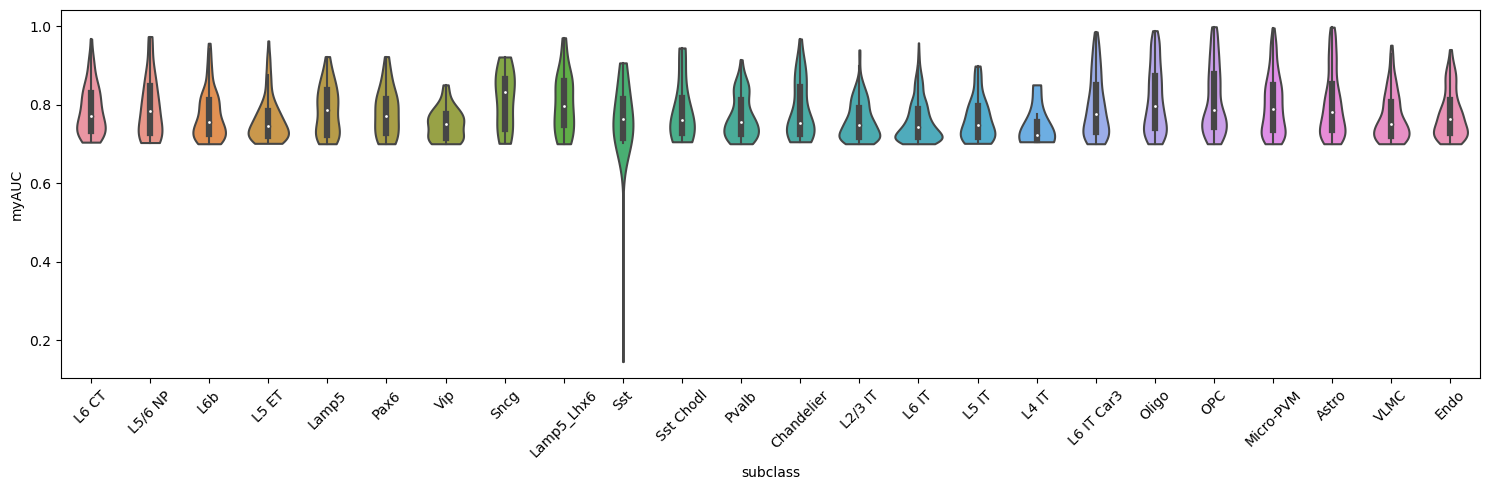

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_df, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [14]:
# reduce to marker genes with AUC above median value per cluster
marker_medians = marker_genes_df.groupby('cluster').median()
marker_genes_reduced = None
for cluster in marker_genes_df['cluster'].unique():
    thresh = marker_medians.loc[cluster]['myAUC']
    gene_filter = marker_genes_df[(marker_genes_df['cluster']==cluster) & (marker_genes_df['myAUC']>thresh)]
    if marker_genes_reduced is None:
        marker_genes_reduced = gene_filter
    else:
        marker_genes_reduced = marker_genes_reduced.append(gene_filter)
        
gene_list = marker_genes_reduced['gene'].tolist()

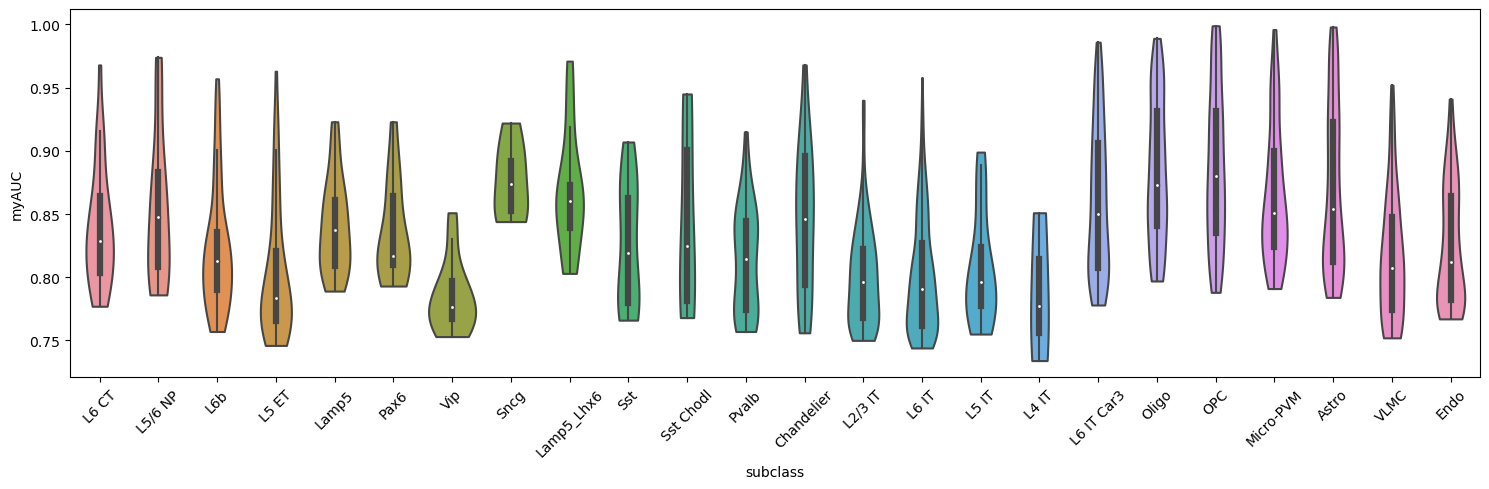

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=marker_genes_reduced, x='cluster', y='myAUC', ax=ax, cut=0)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel('subclass')
plt.tight_layout()

In [16]:
tg_map.set_training_genes(gene_list, meta={'training_genes': 'subclass RNAseq markers above median ROC'})
#Audio(tada, autoplay=True)

starting with 1809 training genes..


INFO:root:139 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:167 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [17]:
# run mapping with default settings:
# device='cpu', mode='clusters', cluster_label='subclass'

tg_map.mapping()
#Audio(tada, autoplay=True)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 139 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.308, KL reg: 0.578
Score: 0.593, KL reg: 0.004
Score: 0.596, KL reg: 0.002
Score: 0.597, KL reg: 0.002
Score: 0.598, KL reg: 0.001
Score: 0.598, KL reg: 0.001
Score: 0.598, KL reg: 0.001
Score: 0.598, KL reg: 0.001
Score: 0.598, KL reg: 0.001
Score: 0.598, KL reg: 0.001


INFO:root:Saving results..


In [20]:
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'barseq',
 'spatial_region': 'MTG',
 'training_genes': 'subclass RNAseq markers above median ROC',
 'mode': 'clusters',
 'cluster_label': 'subclass'}

In [19]:
if not os.path.exists(tg_mapping_path):
    os.mkdir(tg_mapping_path)
tg_map.save_mapping(save_path=tg_mapping_path)
#Audio(tada, autoplay=True)

analysis UID: 1664874329.230


In [5]:
tg_map = TangramMapping.load_from_timestamp(directory=tg_mapping_path, timestamp='1664874329.230')
tg_map.meta

{'snRNAseq': 'logcpm',
 'snRNAseq_region': 'MTG',
 'spatial_method': 'barseq',
 'spatial_region': 'MTG',
 'training_genes': 'subclass RNAseq markers above median ROC',
 'mode': 'clusters',
 'cluster_label': 'subclass'}

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


Running core analysis set..
1) plot training scores of mapping
2) plot mapping probability at each spatial position for each cluster label
3) get and plot the maximum cluster label for each spatial position
4) predict spatial gene expression, plot canonical markers and histogram of scores
          score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
rorb   0.740599         True     0.816464     0.620701       0.195763
cux2   0.716890         True     0.817218     0.524233       0.292986
grik1  0.647915         True     0.856876     0.335638       0.521238


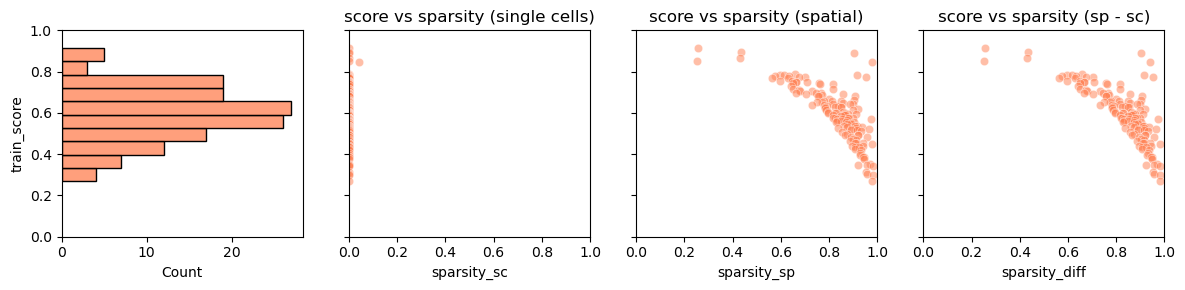

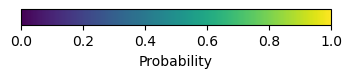

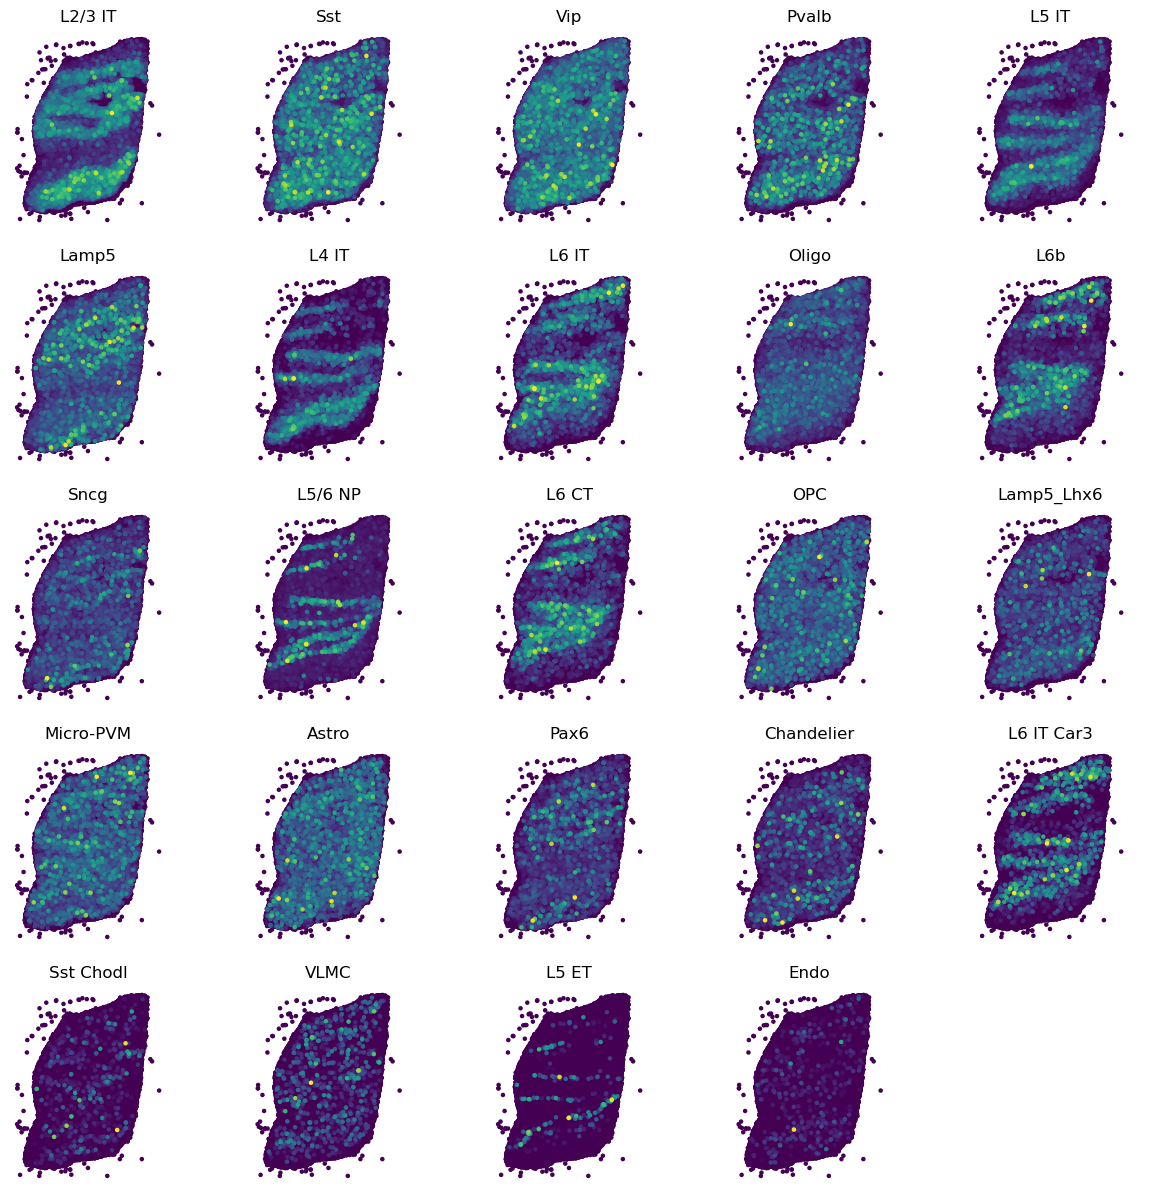

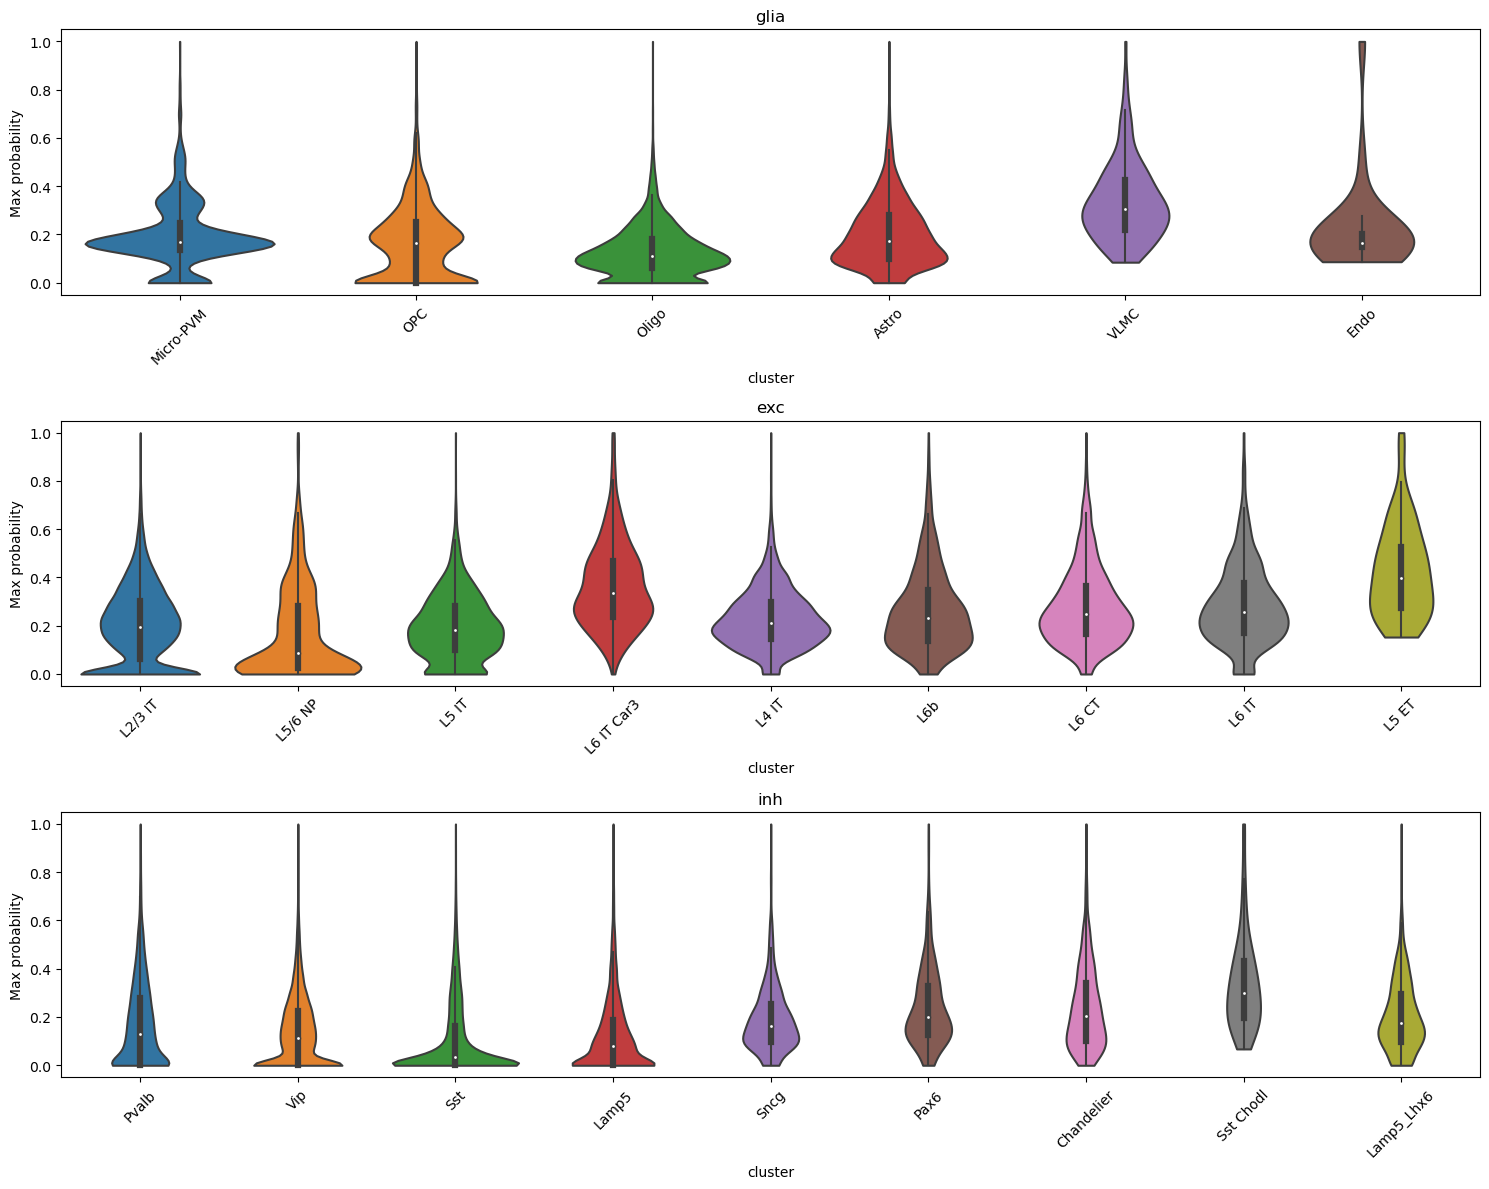

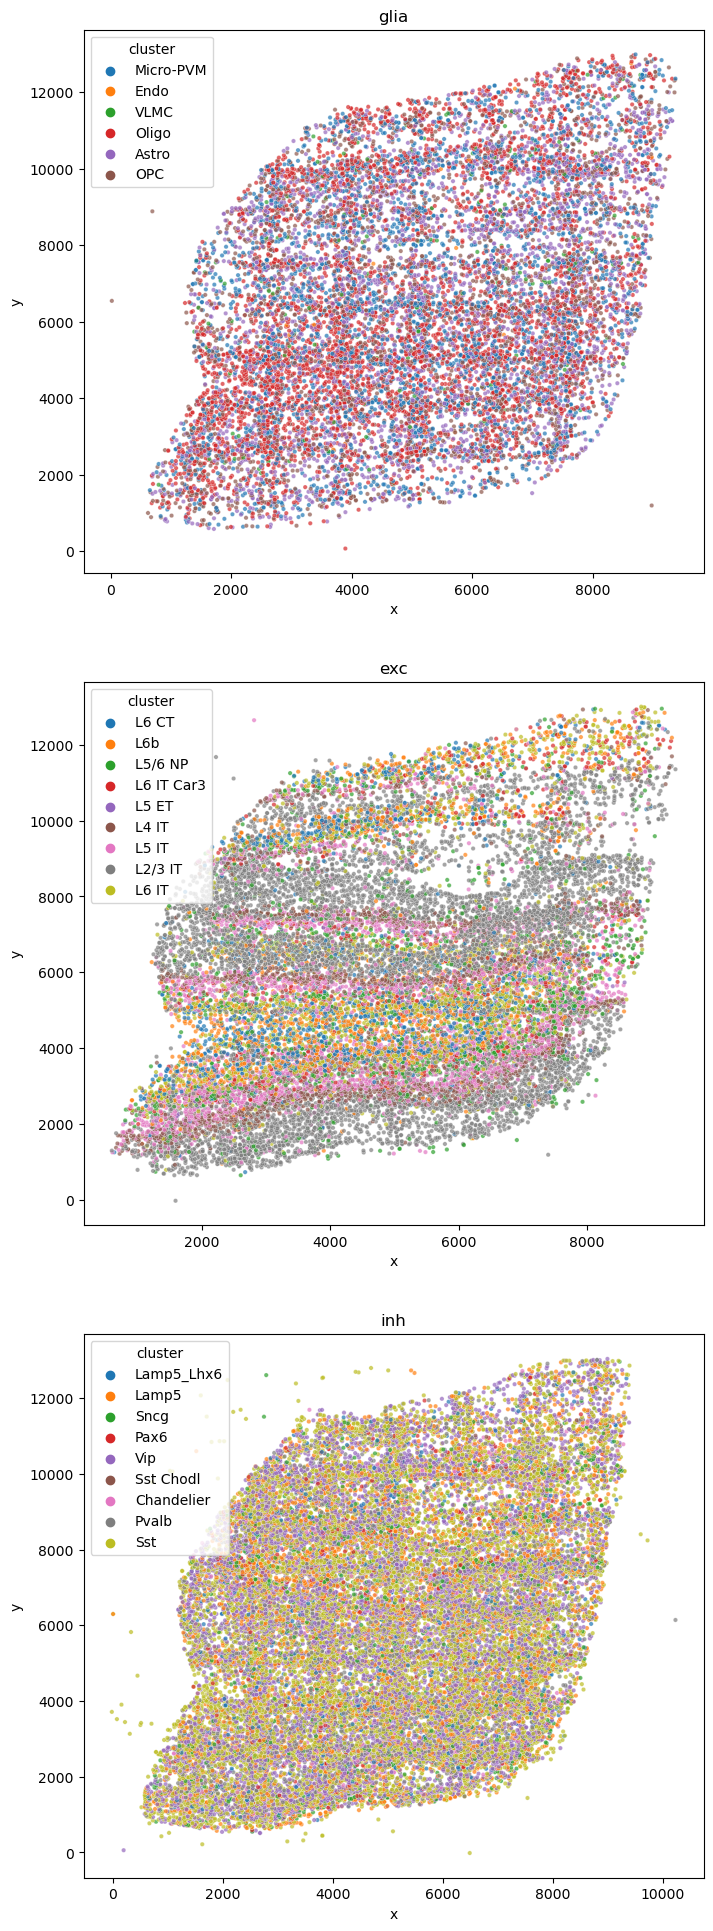

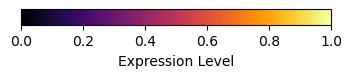

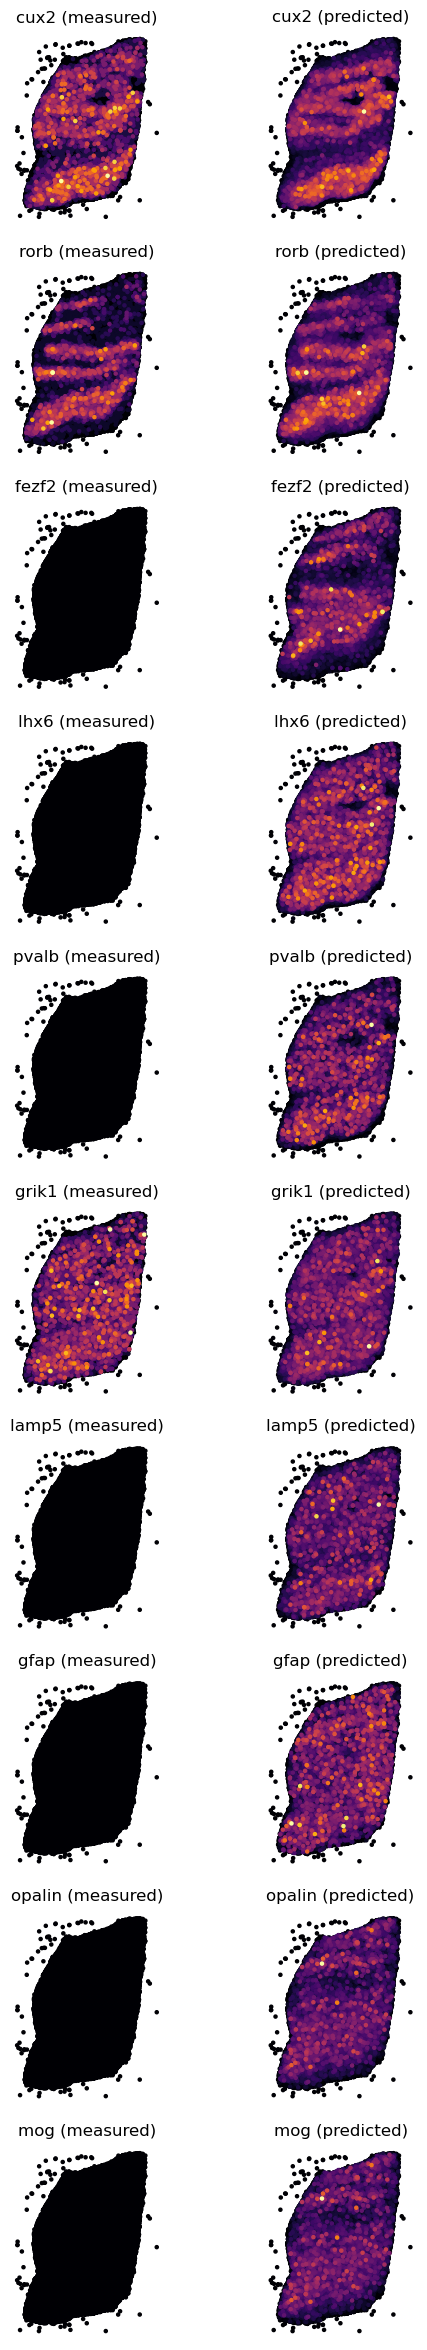

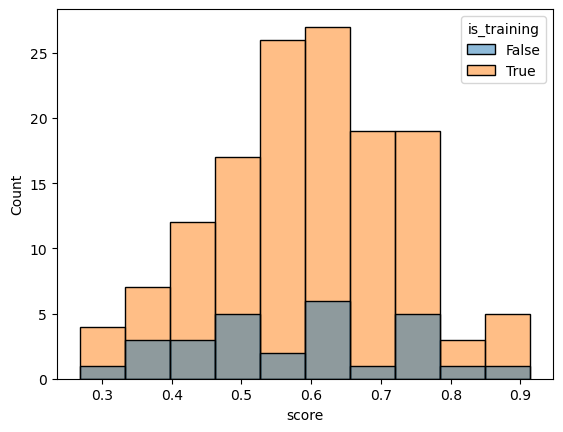

In [6]:
tg_map.evaluate_mapping()

<Figure size 640x480 with 0 Axes>

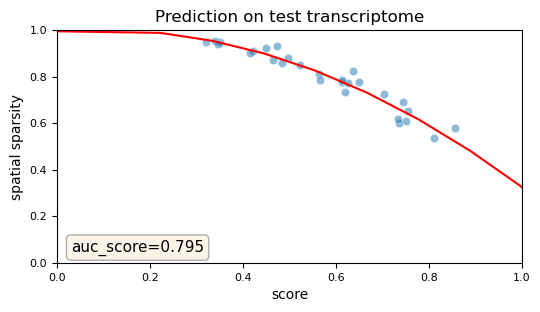

In [7]:
tangram.plot_auc(tg_map.spatial_score)

In [ ]:
tg_map.save_mapping(save_path=tg_mapping_path, file_name='evaluation', replace=True,)             
# Audio(tada, autoplay=True)

(0.0, 1.0)

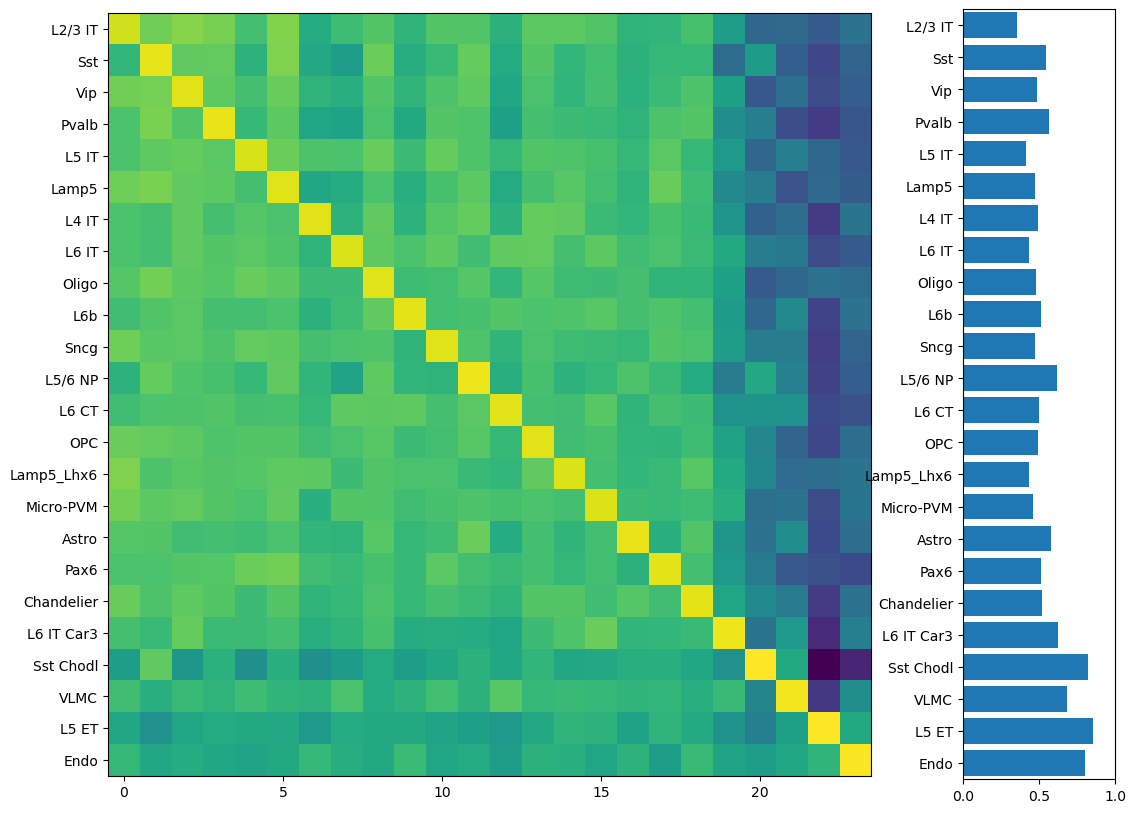

In [31]:
n_types = tg_map.ad_map.X.shape[0]
most_likely_type = tg_map.ad_map.X.argmax(axis=0)

conf_matrix = [[] for i in range(n_types)]
for i in range(tg_map.ad_map.X.shape[1]):
    conf_matrix[most_likely_type[i]].append(tg_map.ad_map.X[:, i])
for i in range(n_types):
    conf_matrix[i] = np.stack(conf_matrix[i], axis=1).sum(axis=1)
    conf_matrix[i] /= conf_matrix[i].sum()
conf_matrix = np.array(conf_matrix)

diff = np.diag(conf_matrix) / conf_matrix.sum(axis=1)



import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, 10))

gs = plt.GridSpec(1, 2, width_ratios=[5,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharey=ax1)

# fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(np.log(conf_matrix))
ax1.set_yticks(np.arange(n_types))
ax1.set_yticklabels(tg_map.ad_map.obs['subclass']);

ax2.barh(np.arange(n_types), diff)
ax2.set_yticks(np.arange(n_types))
ax2.set_yticklabels(tg_map.ad_map.obs['subclass']);
ax2.set_xlim(0, 1)

